

<font size = "5"> **Chapter 2: [Diffraction](CH2_00-Diffraction.ipynb)** </font>

<hr style="height:1px;border-top:4px solid #FF8200" />

# CBED - Multislice Algorithm

[Download](https://raw.githubusercontent.com/gduscher/MSE672-Introduction-to-TEM//main/Diffraction/CCH2_D02-Multi_Slice.ipynb)
 
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
    https://colab.research.google.com/github/gduscher/MSE672-Introduction-to-TEM/blob/main/Diffraction/CH2_D02-Multislice.ipynb)


part of 

<font size = "5"> **[MSE672:  Introduction to Transmission Electron Microscopy](../_MSE672_Intro_TEM.ipynb)**</font>

by Gerd Duscher, Spring 2021

Microscopy Facilities<br>
Joint Institute of Advanced Materials<br>
Materials Science & Engineering<br>
The University of Tennessee, Knoxville

Background and methods to analysis and quantification of data acquired with transmission electron microscopes


## Introduction
In this notebook, we will make a dynamic simulation of the scattering process.

The core of this algorithm is used in many different libraries.

I follow in my description mostly the book of Kirkland, from where we also use the scattering parameters. The code has been completely rewritten so that the mechnaism of the algorithm can be understood on a basic level. 

All commercial and open-source codes use the same base algorithm but are highly tuned for usability, variabilty, features and speed. This was not the goal here.

Here are a few of the more common open-source programs
- [abTEM](https://github.com/jacobjma/abTEM)
- [clTEM](https://github.com/JJPPeters/clTEM)
- [MuSTEM](https://github.com/ningustc/MuSTEM)
- [Dr. Probe](https://er-c.org/barthel/drprobe/)


## Load relevant python packages
### Check Installed Packages

In [1]:
import sys
from pkg_resources import get_distribution, DistributionNotFound

def test_package(package_name):
    """Test if package exists and returns version or -1"""
    try:
        version = get_distribution(package_name).version
    except (DistributionNotFound, ImportError) as err:
        version = '-1'
    return version

# Colab setup ------------------
if 'google.colab' in sys.modules:
    !pip install pyTEMlib -q
# pyTEMlib setup ------------------
else:
    if test_package('pyTEMlib') < '0.2021.2.22':
        print('installing pyTEMlib')
        !{sys.executable} -m pip install  --upgrade pyTEMlib -q
# ------------------------------
print('done')

done


### Import numerical and plotting python packages
Import the python packages that we will use:

Beside the basic numerical (numpy) and plotting (pylab of matplotlib) libraries, we need 3D plotting library and some scipy libraries

and a library from pyTEMlib:
* kinematic scattering library.

In [2]:
import sys
if 'google.colab' in sys.modules:
    %pylab --no-import-all inline
else:
    %pylab --no-import-all notebook

# additional package 
from mpl_toolkits.mplot3d import Axes3D 
import itertools
import scipy.constants
import scipy.special 

# Import libraries from pyTEMlib
import sys
sys.path.insert(0,'../../pyTEMlib/')
%load_ext autoreload
%autoreload 2

import pyTEMlib
import pyTEMlib.KinsCat as ks         # Kinematic sCattering Library
                             # Atomic form factors from Kirklands book
import pyTEMlib.dynamic_scattering 

# For archiving reasons it is a good idea to print the version numbers out at this point
print('pyTEM version: ',pyTEMlib.__version__)

__notebook__ = '2_Image_Registration'
__notebook_version__ = '2021_03_05'

Populating the interactive namespace from numpy and matplotlib
Using KinsCat library version  0.5  by G.Duscher
spglib not installed; Symmetry functions of spglib disabled
Using kinematic_scattering library version  0.6  by G.Duscher
spglib not installed; Symmetry functions of spglib disabled
pyTEM version:  0.2021.03.02


C:\Users\gduscher\Anaconda3\lib\site-packages\pyUSID\viz\__init__.py:16: FutureWarning: Please use sidpy.viz.plot_utils instead of pyUSID.viz.plot_utils. pyUSID.plot_utils will be removed in a future release of pyUSID
  warn('Please use sidpy.viz.plot_utils instead of pyUSID.viz.plot_utils. '


## Overview of Multislice Algorithm

We build on top of the [Multislice notebook](CH2_D02-Multislice.ipynb) 

1. Make projected atomic potentials of slices.
2. The transmission function will deal with the distorition of the wave by the atom potentials.
3. The Fresnel propagator takes care of the vacuum between the atomic layers.
4. We need to define the `` convergent`` incident wave. 
5. We let this wave travel through the different layers, iteratively.


## Step1: Projected Potential 

Providing the potentials and placing the atoms is a surprisingly computer intensive task for initialization of the simulation. This notebook gives up flexibility for speed in placing the atoms (no sub-pixel movement).



### Slice Crystal.

The above crystal is an artificial construct.

Now we make a real crystal. 

>
> For the multislice alogrythm we need to make the slices.
>

We do this here on the based on the unit cell 


0 Sr [0. 0. 0.]
1 Ti [0.5 0.5 0.5]
2 O [0.5 0.  0.5]
3 O [0.5 0.5 0. ]
4 O [0.  0.5 0.5]


<IPython.core.display.Javascript object>


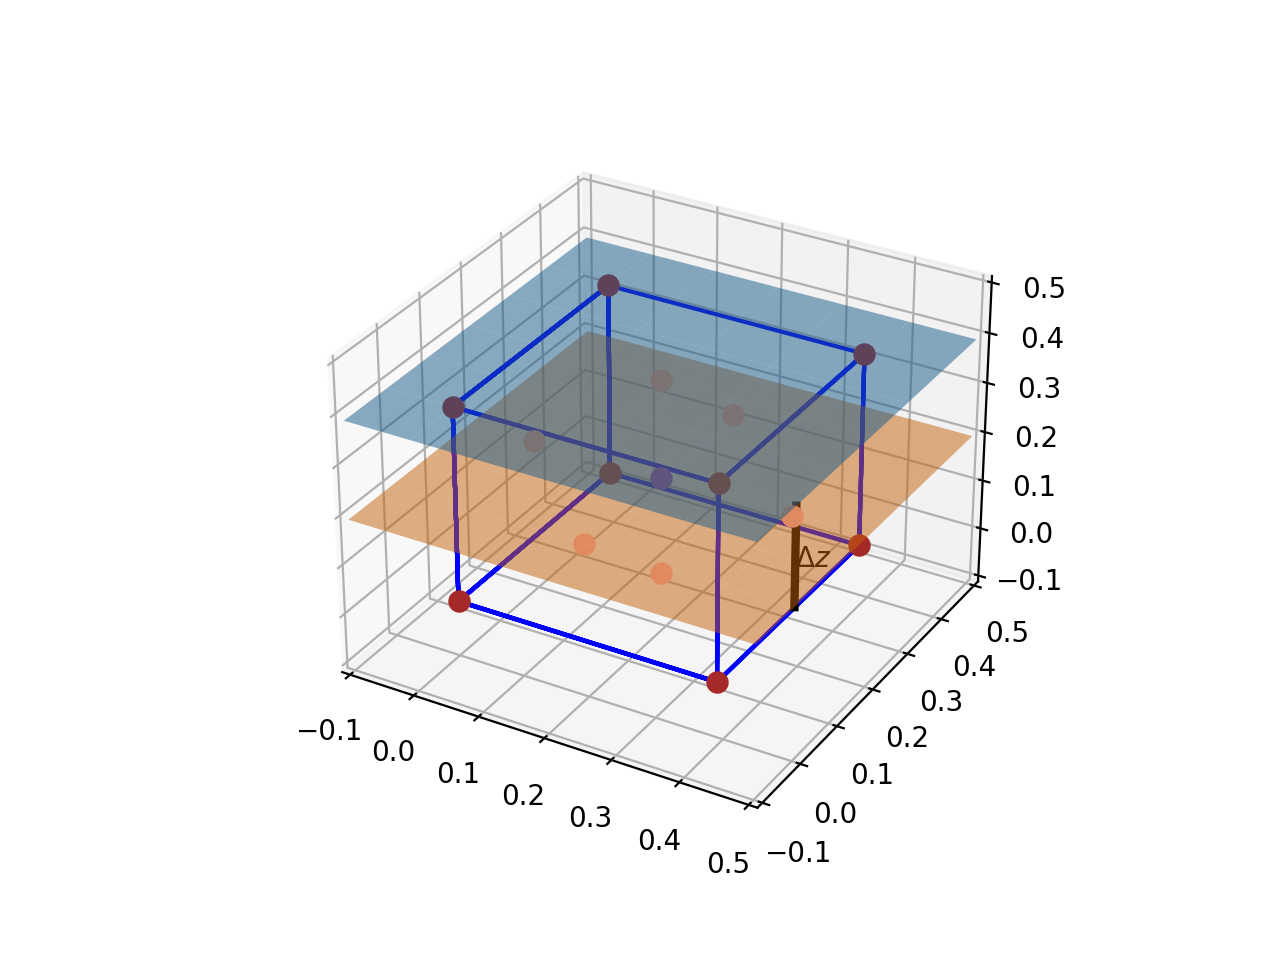

In [3]:
tags = ks.structure_by_name('SrTiO3')
for i in range(len(tags['base'])):
    print(i, tags['elements'][i], tags['base'][i])

corners, balls, atomic_number, bonds = ks.ball_and_stick(tags)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
        
cell = tags['unit_cell']

# Corners and Outline of unit cell
h = (0, 1)
corner_vectors = np.dot(np.array(list(itertools.product(h, h, h))), cell)
trace = [[0, 1], [1, 3], [3, 2], [2, 0], [0, 4], [4, 5], [5, 7], [6, 7], [6, 4], [1, 5], [2, 6], [3, 7]]
corners = []
for s, e in trace:
    corners.append([*zip(corner_vectors[s], corner_vectors[e])])

    for x, y, z in corners:
        ax.plot3D(x, y, z, color='blue')

for i, atom in enumerate(balls):
    ax.scatter(atom[0], atom[1], atom[2],
               color=tuple(ks.jmol_colors[atomic_number[i]-4]),
               alpha=1.0, s=50)
xx, yy = np.meshgrid(range(-1,6), range(-1,6))
z = xx*0+cell[2][2]
ax.plot_surface(xx/10, yy/10, z, alpha=0.5)
ax.plot_surface(xx/10, yy/10, z-cell[2][2]/2, alpha=0.5)
ax.text(0.5, 0., cell[2][2]*.7, "$\Delta z$", color='black')
ax.plot([0.5, 0.5], [0,0],zs=[cell[2][2]/2, cell[2][2]], color='black', linewidth=3)
ax.set_xlim(-0.1, 0.5)
ax.set_ylim(-0.1, 0.5)
ax.set_zlim(-0.1, 0.5);

Here we have two equidistant layers that we can read off the z-component of the base 
- one layer with z = 0.0 and 
- one layer with z = 0.5

### Make Potentials for Slice

<IPython.core.display.Javascript object>


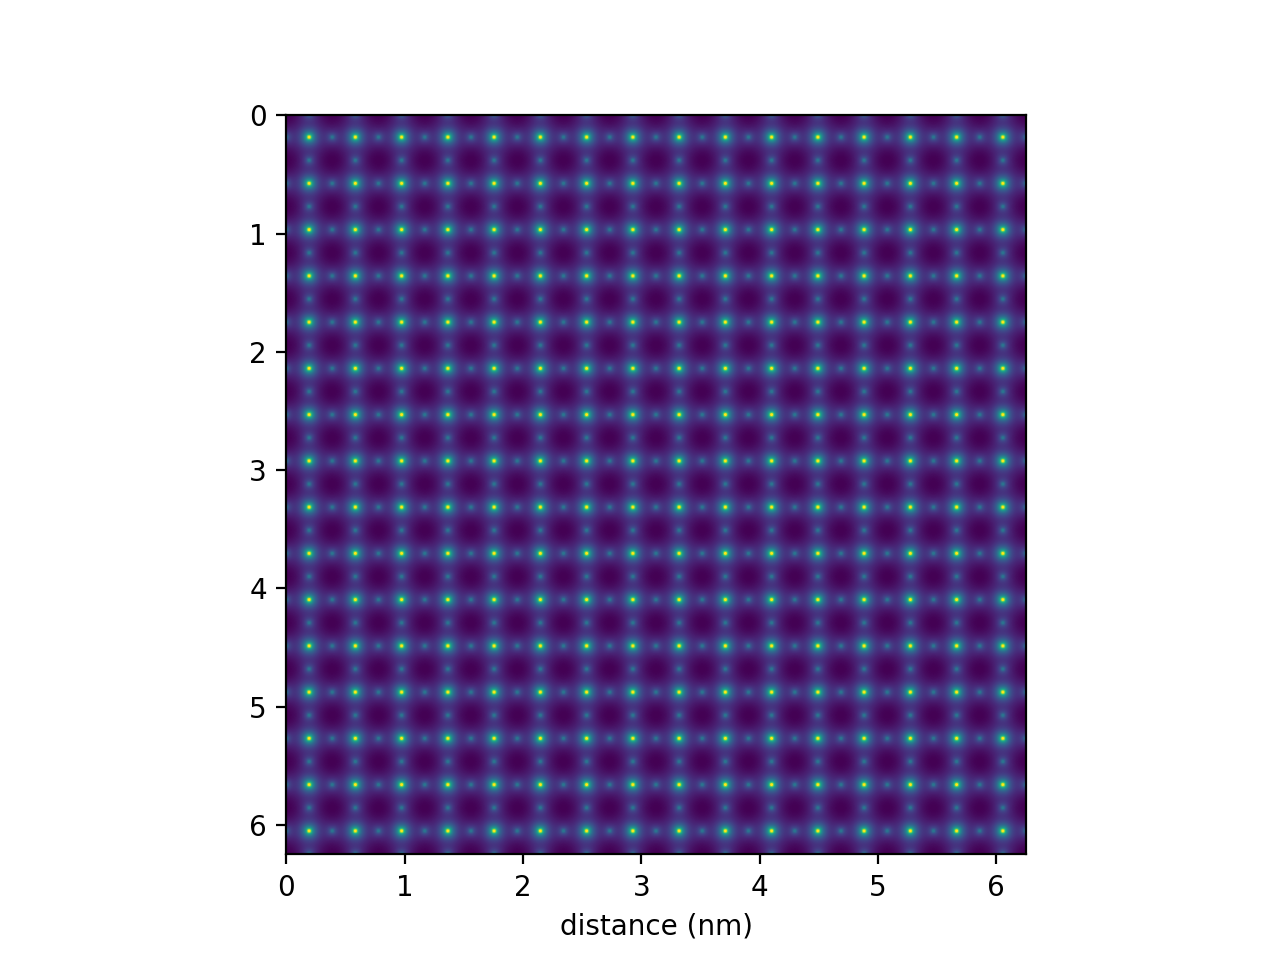

In [28]:
# ------Input --------
size_in_pixel = 512*2
n_cell_x = 16
# --------------------

tags = ks.structure_by_name('SrTiO3')

lattice_parameter = a = tags['unit_cell'][0][0]
pixel_size = lattice_parameter/(size_in_pixel/n_cell_x)

positions = np.dot(tags['base'], tags['unit_cell'])  # in pixel

layers = {}
layers[0] ={0:{'element': 'Sr', 'base': [tags['base'][0, 0:2]]}, 
            1:{'element': 'O',  'base': [tags['base'][3, 0:2]]}}
layers[1] ={0:{'element': 'Ti', 'base': [tags['base'][1, 0:2]]}, 
            1:{'element': 'O',  'base': tags['base'][[2,4], 0:2]}} 


a = tags['unit_cell'][0,0]

pixel_size = a/(size_in_pixel/n_cell_x)

image_extent = [0, size_in_pixel*pixel_size, size_in_pixel*pixel_size,0]
slice_potentials = np.zeros([2,size_in_pixel,size_in_pixel])
for layer in layers:
    for atom in layers[layer]:
        elem = layers[layer][atom]['element']
        pos = layers[layer][atom]['base']
        slice_potentials[layer] += pyTEMlib.dynamic_scattering.potential_2dim(elem, size_in_pixel, size_in_pixel, n_cell_x, n_cell_x, a, pos)
plt.figure()
#plt.imshow(layer_potentials.sum(axis=0))
plt.imshow(slice_potentials[1], extent = image_extent)
plt.xlabel('distance (nm)')
plt.show()

## Step 3: Transmission Function for Each Slice 

The slice acts like a **Very Thin Specimen** in the ``weak phase approximation``.
In that approximation, the sample causes only a phase change to the incident plane wave.

To retrieve the exit wave of that slice we just multiply the transmission function $t(\vec{x})$ with the plane wave $\exp (2\pi i k_z z)$

$$ \Psi_t(\vec{x}) = t(\vec{x}) \exp \left(2 \pi i k_z z \right) \approx t(\vec{x})  $$

The specimen transmission function depends on the projected potential $v_z(\vec{x})$ and the interaction parameter $\sigma$:
$$t(\vec{x}) =  \exp \left( i \sigma v_z(\vec{x})\right)$$

with the interaction parameter $\sigma$:
$$ 
\sigma = \frac{2 \pi}{\lambda V} \left(  \frac{m_0 c^2 + eV}{2m_0c^2+eV} \right) = \frac{2 \pi m  e_0 \lambda}{h^2}
$$
with $ m = \gamma m_0$ and $eV$ the incident electron energy.

<IPython.core.display.Javascript object>


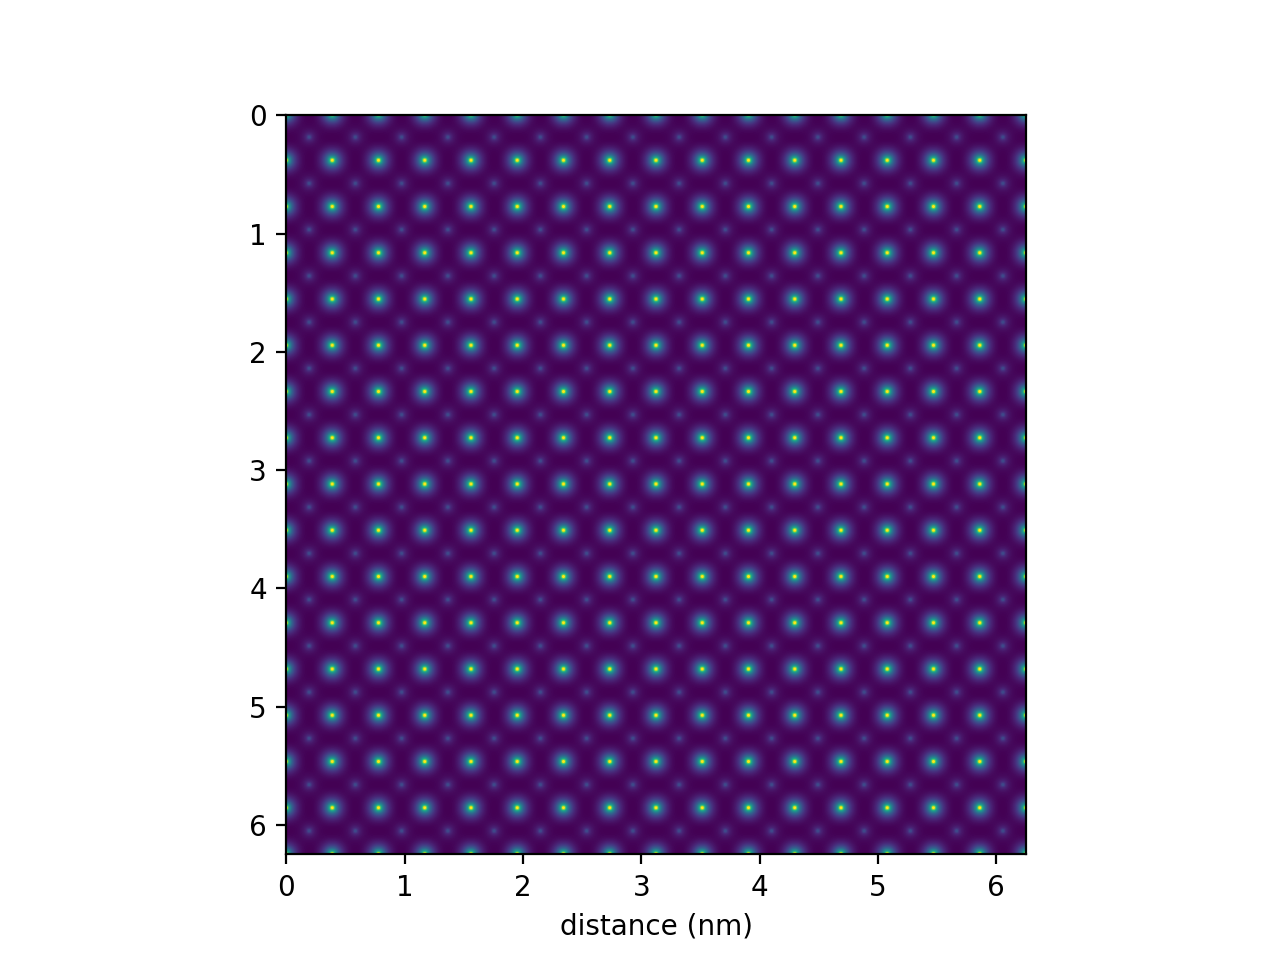

In [29]:
acceleration_voltage = 60*1e3

transmission = pyTEMlib.dynamic_scattering.get_transmission(slice_potentials, acceleration_voltage)

plt.figure()
plt.imshow(transmission[0].imag, extent = image_extent)
plt.xlabel('distance (nm)');

## Step 4: Propagator
The Fresnel propagator $p$ propagates the wave through the vacuum of the layers between the (flat) atom potentials.
$$
p(x,y, \Delta z) = \mathcal{F} P(k_x, k_y, \Delta z)
$$
Mathematically, this propagator function has to be  convoluted with the wave, which is a multiplication in Fourier space $\mathcal{F}$.

$$
P(k,\Delta z) = \exp(-i\pi \lambda k^2 \Delta z)
$$

The Fourier space is limited in reciprocal vector to avoid aliasing. We realize that with  an aperture function.

Here we assume a cubic crystal and equidistant layers, but that of course is not always true.

[0.1952634, 0.1952634]
54.62706614074458
Bandwidth limited to a real space resolution of 18.30594375 pm
   (= 265.82 mrad)  for symmetrical anti-aliasing.
Number of symmetrical non-aliasing beams = 366072


<IPython.core.display.Javascript object>


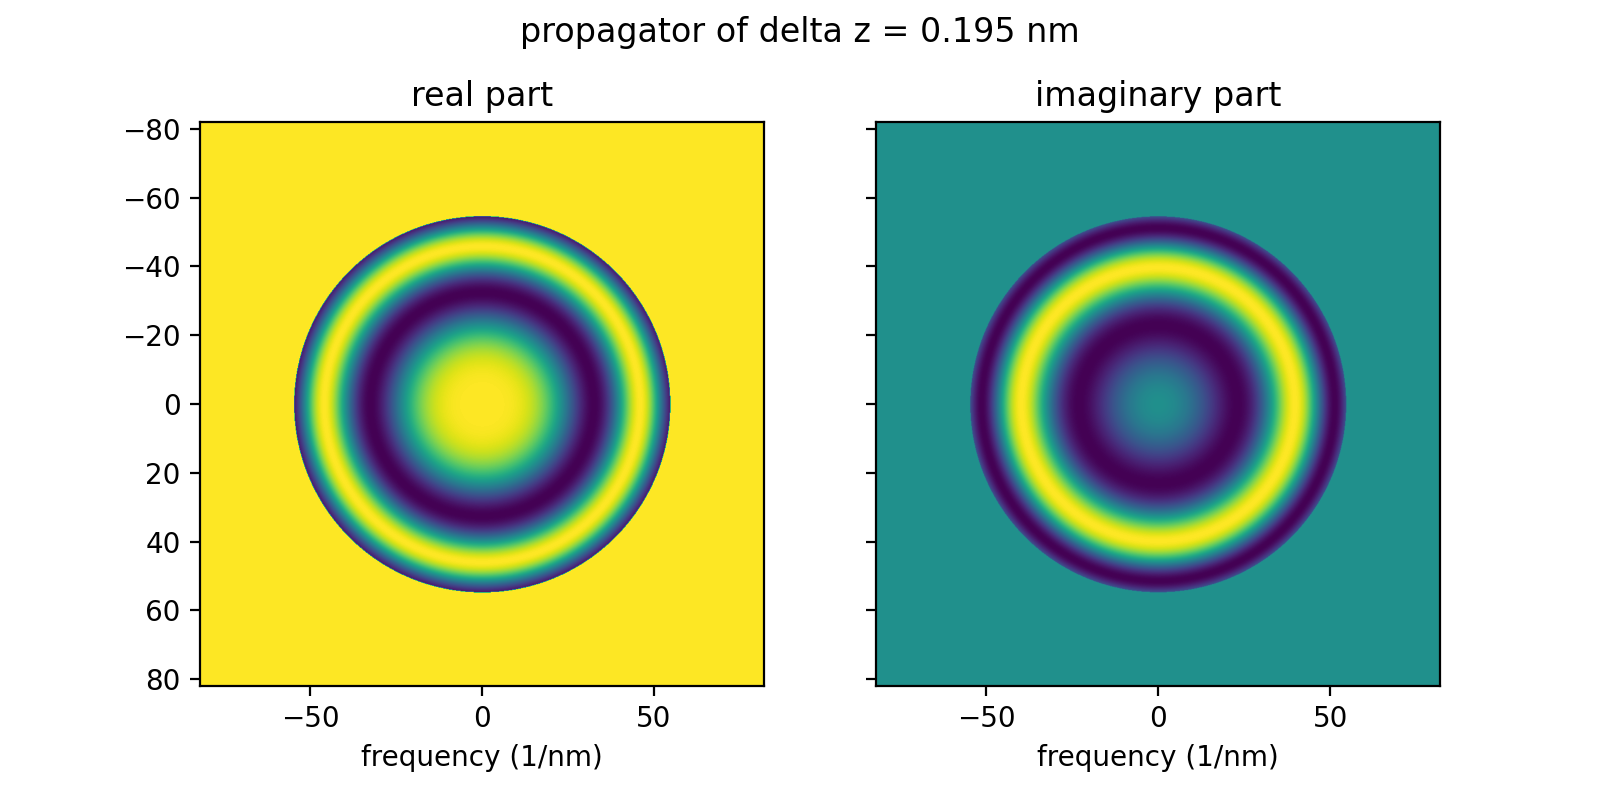

In [30]:

lattice_parameter = tags['unit_cell'][0,0]
field_of_view = n_cell_x*lattice_parameter
number_layers = 2
delta_z = [tags['unit_cell'][2,2]/number_layers, tags['unit_cell'][2,2]/number_layers]
print(delta_z)
wavelength = ks.get_wavelength(acceleration_voltage)

bandwidth_factor = 2/3   # Antialiasing bandwidth limit factor

propagator = pyTEMlib.dynamic_scattering.get_propagator(size_in_pixel, delta_z, number_layers, wavelength, field_of_view, 
                             bandwidth_factor, verbose=True)

recip_FOV = size_in_pixel/field_of_view/2.
reciprocal_extent = [-recip_FOV,recip_FOV,recip_FOV,-recip_FOV]
layer = 0
fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
fig.suptitle(f"propagator of delta z = {delta_z[layer]:.3f} nm")
ax[0].set_title(f"real part")
ax[0].imshow(propagator[0].real,extent=reciprocal_extent)
ax[0].set_xlabel('frequency (1/nm)')
ax[1].set_title(f"imaginary part")
ax[1].set_xlabel('frequency (1/nm)')
ax[1].imshow(propagator[0].imag,extent=reciprocal_extent)


## Step 5: Incident Wave

The definition of the incident wave is the only fundamental change compared to the [SAED multislice notebook](CH2-D02-Multislice.ipynb)

We take advantage from the fact that aperfect convergent probe in reciprocal space is the Fourier transform of an aperture function (probe forming aperture) which is perfectly coherently illuminated (all amplitudes and phases the same). 

I'll use the fft_shift function to put the probe in the middle, which is on top of a Sr column.


Convergence angle is 6.33 mrad


<IPython.core.display.Javascript object>


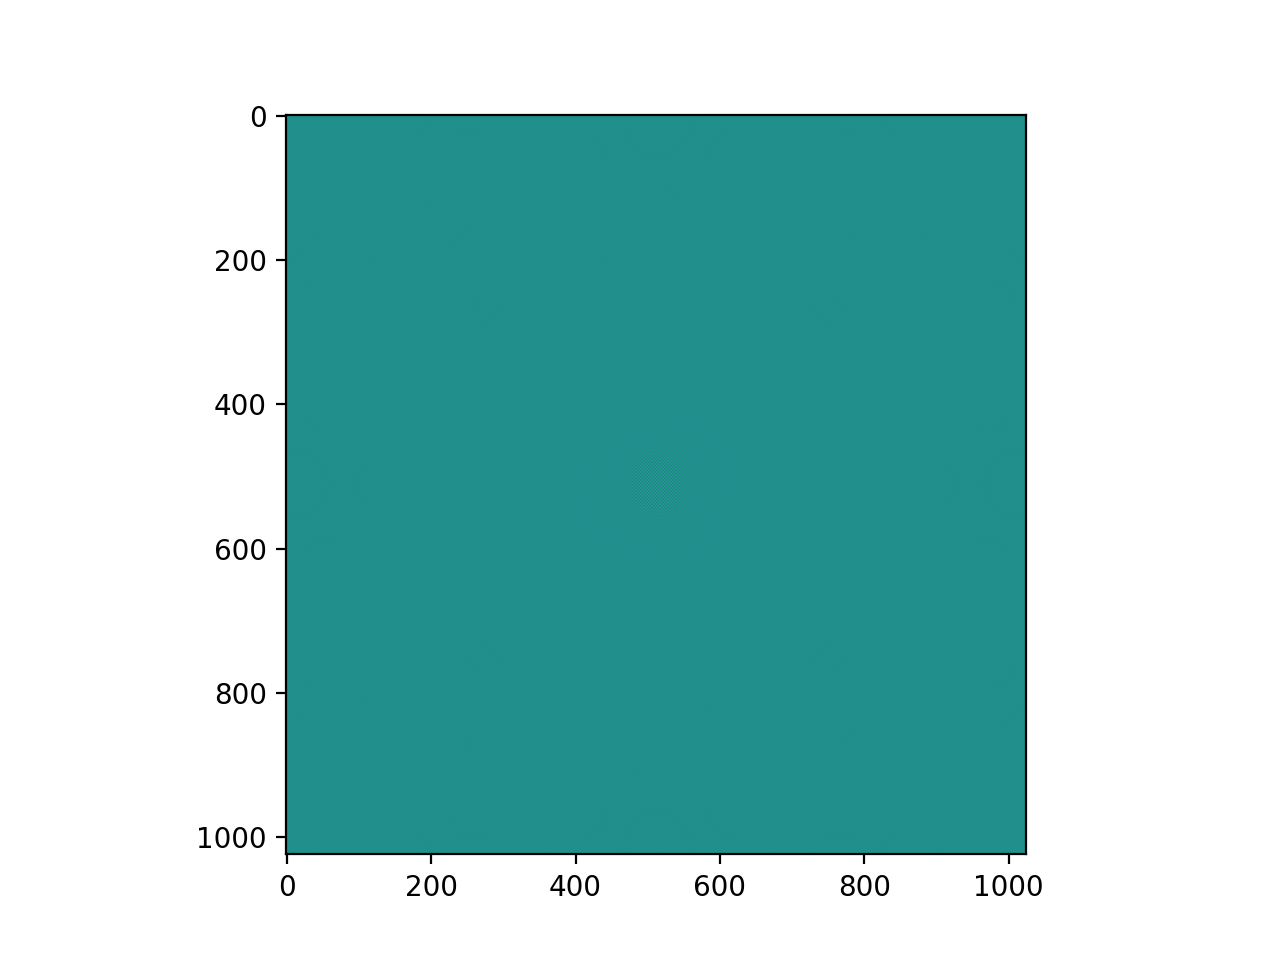

In [31]:
# --- Input ------------
convergence_angle = 1.3 # in 1/nm
# ----------------------
print(f'Convergence angle is {wavelength*convergence_angle*1000:.2f} mrad')
# aperture function
dk = 1 / field_of_view
k = np.array(dk * (-size_in_pixel / 2. + np.arange(size_in_pixel)))
t_xv, t_yv = np.meshgrid(k, k)
theta = np.sqrt(t_xv ** 2 + t_yv ** 2)

aperture_function = np.zeros([size_in_pixel,size_in_pixel], dtype=complex)
aperture_function[theta<convergence_angle] = 1.

incident_wave = np.fft.fftshift(np.fft.ifft2(aperture_function))

plt.figure()
plt.imshow(incident_wave.real)

## Step 6: Multislice Loop

Combining the transmission function $t$ and the Frensel propagator $p$ we get
for each slice:
$$
\Psi(x,y,z+\Delta z) = p(x,y,\Delta z) \otimes \left[t(x,y,z)\Psi(x,y,z) \right] + \mathcal{O}(\Delta z^2)
$$

or an expression that bettere relfects the iterative nature of this equation for starting layer n :

$$
\Psi_{n+1}(x,y,) = p_n(x,y,\Delta z) \otimes \left[t_n(x,y,z)\Psi_n(x,y,z) \right] + \mathcal{O}(\Delta z^2)
$$

Again the convolution $\otimes$ will be done as a multiplication in Fourier space.

simulated SrTiO3 for thickness 15.621 nm


<IPython.core.display.Javascript object>


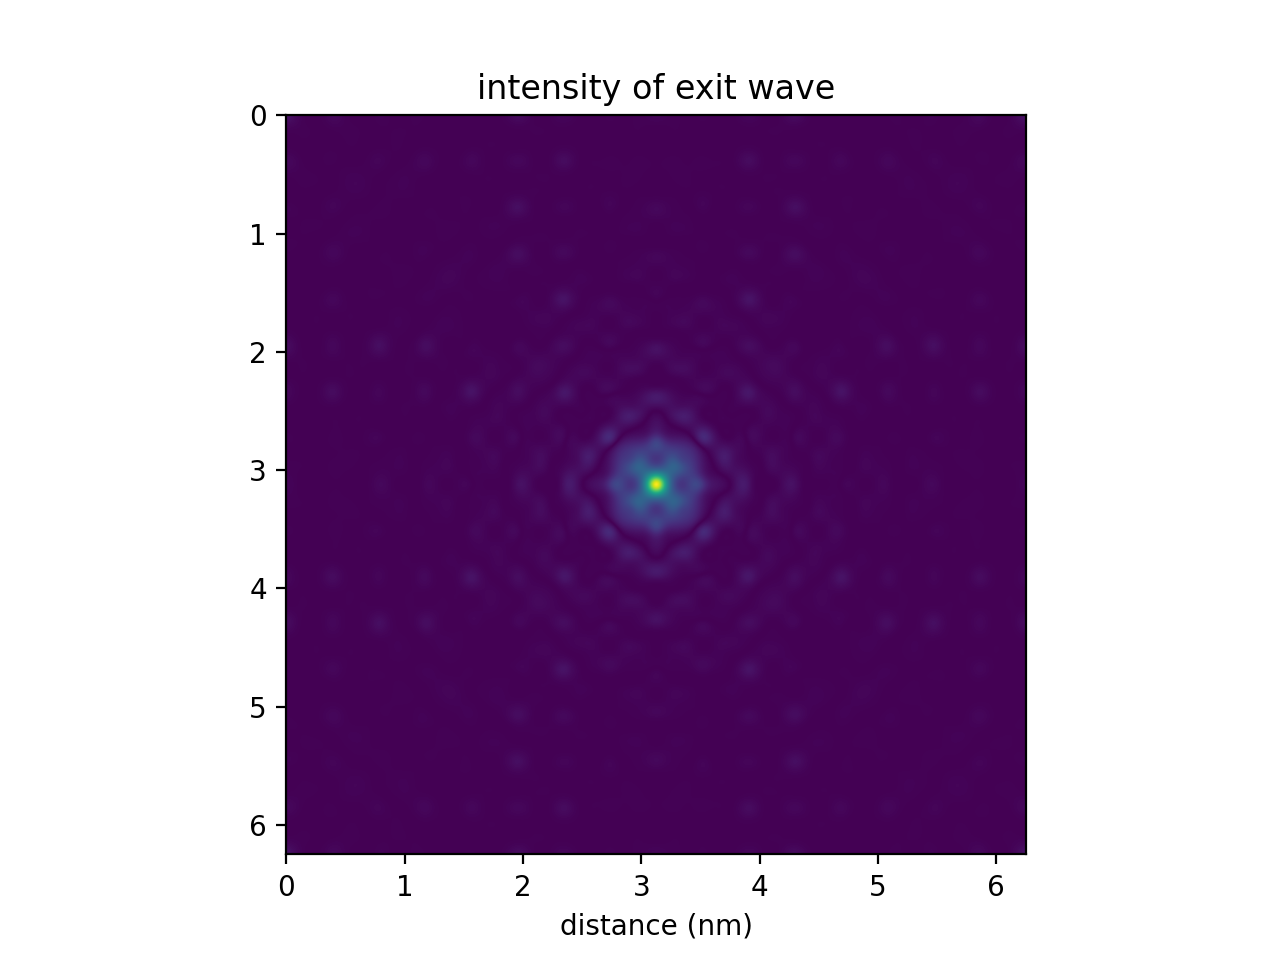

In [32]:
# ------Input------------- #
number_of_unit_cell_z = 40 # this will give us the thickness
# ------------------------ #    

number_of_layers = 2
exit_wave = pyTEMlib.dynamic_scattering.multi_slice(incident_wave, number_of_unit_cell_z, number_of_layers, transmission, propagator)
    
print(f"simulated {tags['crystal_name']} for thickness {number_of_unit_cell_z*tags['unit_cell'][0,0]:.3f} nm")

wave = np.fft.fft2(exit_wave)
intensity = np.abs(np.fft.fftshift(np.fft.ifft2(wave*np.conjugate(wave))))

plt.figure()
plt.title('intensity of exit wave')
plt.imshow(intensity, extent = image_extent)
plt.xlabel('distance (nm)');

## Diffraction Pattern

according to [J. M. Cowley and A. F. Moodie](https://doi.org/10.1107/S0365110X57002194), the diffraction pattern $U(u,v)$ is the Fourier transform of the exit wave function in the far-field (diffraction plane): 

$$
U(u,v) = \mathcal{F} \left( \exp(i*\varphi(x,y)) \right)
$$

where $\varphi$ is the exit wave of the crystal.

<IPython.core.display.Javascript object>


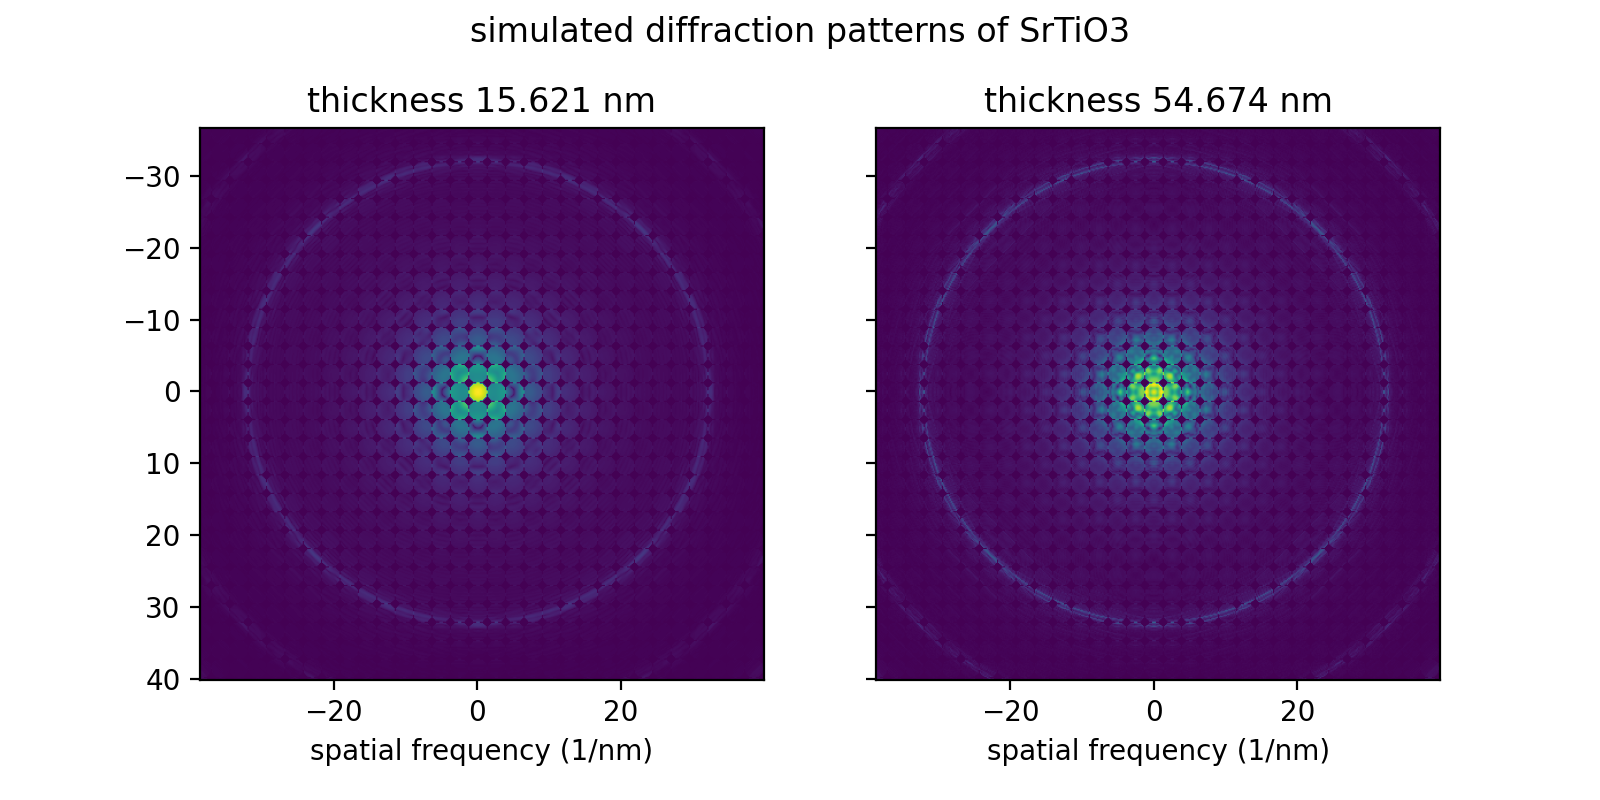

In [33]:
# -----Input-----------
additional_layers = 100
# ---------------------
diffraction_pattern =  np.fft.fft2(np.exp(1j*exit_wave))
diffraction_pattern[0,0] = 0

# adding a multislice calculation
exit_wave2 = pyTEMlib.dynamic_scattering.multi_slice(exit_wave, additional_layers, number_of_layers, transmission, propagator)
diffraction_pattern2 = np.fft.fft2(np.exp(1j*exit_wave2))
diffraction_pattern2[0,0] = 0

fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
fig.suptitle(f"simulated diffraction patterns of {tags['crystal_name']}")
ax[0].set_title(f"thickness {number_of_unit_cell_z*tags['unit_cell'][0,0]:.3f} nm")
ax[0].imshow(np.power(np.abs(diffraction_pattern),.5), extent=reciprocal_extent)
ax[0].set_xlabel('spatial frequency (1/nm)')
ax[1].set_title(f"thickness {(number_of_unit_cell_z+additional_layers)*tags['unit_cell'][0,0]:.3f} nm")
ax[1].imshow(np.power(np.abs(diffraction_pattern2),.5), extent=reciprocal_extent)
ax[1].set_xlabel('spatial frequency (1/nm)')

ax[1].set_aspect('equal')
#ax[1].set_xlim(-20,20)
#ax[1].set_ylim(-20,20)

## Sampling in Real- and Reciprocal space

The real-space sampling is extremely important because it controls the accuracy of the simulation at high scattering angles. Especially in CBED calculations, we ususally want to see the zero disk with lots of pixels and include the HOLZ rings, so we need to think about sampling in real space affects the reciprocal space.

The sampling defines the maximum spatial frequency $k_{max}$

via the formula:

$$k_{max}=\frac{2}{p},$$

where $p$ is the real-space sampling distance otherwise called pixel size. 

Because, we have the same number of pixels in real and reciprocal space the sampling of one space influences the other according to above equation.

To counteract aliasing artifacts due to the periodicity assumption of a discrete 
Fourier transform, abTEM supresses spatial frequencies above $\frac{2}{3}$ of the 
maximum scattering angle, further reducing the maximum effective scattering angle by a 
factor of $\frac{2}{3}$. 

Hence the maximum scattering angle $\alpha_{max}$
is given by:
$$\alpha_{max} =  \frac{2}{3} \frac{\lambda}{2p}$$

where $\lambda$ is the relativistic electron wavelength.

>
>As an example, consider a case where we want to simulate 80 keV electron scattering up 
to angles of 200 mrads. Plugging these values into the above equation gives a 
sampling of ∼0.0052 nm.
>
>Therefore, we require at least 5pm pixel size in order to reach a maximum scattering angle of 200 mrads. 

**In practice, you should ensure that the simulation is converged with respect to pixel size.**


## Summary

The multislice algrithm allows to calculate all the dynamic diffraction effects we need. 

Changing the incident wave from a palne to a convergent one is all one needs to do to simulate CBED patterns.

More sophisticated program allowmore flexibility and include frozen phonon calculatins and differ

